In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import anndata as ad 
import scanpy as sc
sys.path.append("../../")
import utils
from sklearn.decomposition import PCA
import umap
import graph
import visualize

In [5]:
## read in all the stuff

cnngnn_embed = np.load("/home/bkzhu/spatial_clustering/phase3/spatial-clust-scripts-main/data/tonsil/cnn_l2_layer6_epoch400_gnn_embedding_dim32.npy")
train_mask = np.load("/home/bkzhu/spatial_clustering/phase3/spatial-clust-scripts-main/data/tonsil/train_mask_tonsil.npy")
df = pd.read_csv("/home/bkzhu/spatial_clustering/phase2/data/tonsil/results/all_clusters.csv")
gnn_embed = np.load('/home/bkzhu/spatial_clustering/phase3/spatial-clust-scripts-main/data/tonsil/gnn_embedding_dim32_tonsil.npy')

In [6]:
df['xreg'] = df['PointNum'].str.split('_',expand=True)[1].str[1:].astype(int)
df['yreg'] = df['PointNum'].str.split('_',expand=True)[2].str[1:].astype(int)
df_sub = df.loc[(df.yreg >= 8) & (df.yreg <= 13) & (df.xreg <= 8) & (df.xreg >= 4),:]
df_sub = df_sub.loc[~df_sub['cluster.term'].isin(['mix','Other']),:]

In [7]:
# get train masked cells
cnngnn_embed_sub = cnngnn_embed[train_mask,:]
features_sub = df_sub.iloc[train_mask,4:-6].to_numpy()
gnn_embed_sub = gnn_embed[train_mask,:]

# then we get 10k sub set cells for testing
indices = np.random.choice(cnngnn_embed_sub.shape[0], 10000, replace=False)
cnngnn_embed_sub = cnngnn_embed_sub[indices]
features_sub = features_sub[indices]
gnn_embed_sub = gnn_embed_sub[indices]

No handles with labels found to put in legend.


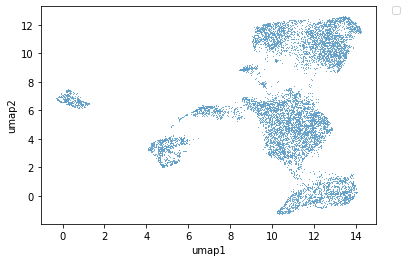

In [8]:
# protein only

features = features_sub
features_after_pca = features # for consistency, no pca done
umap_fit = umap.UMAP(random_state=42)
umap_embed_feature = umap_fit.fit_transform(features_after_pca)

# plot out
umap_embed_feature_df = pd.DataFrame(umap_embed_feature, columns = ['umap1', 'umap2'])
#umap_embed_feature_df['type'] = df['cluster.term'].values[indices]
#sns.scatterplot(data=umap_embed_feature_df, x='umap1', y='umap2', hue='type', s=1)
sns.scatterplot(data=umap_embed_feature_df, x='umap1', y='umap2', s=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

No handles with labels found to put in legend.


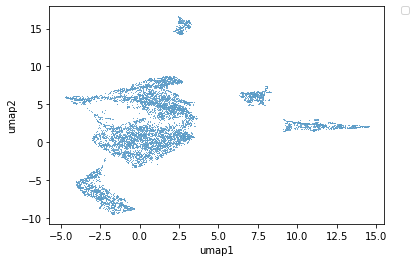

In [9]:
# vanilla gnn

gnn_after_pca = gnn_embed_sub
umap_fit = umap.UMAP(random_state=42)
umap_embed_gnn = umap_fit.fit_transform(gnn_after_pca)

# plot out
umap_embed_gnn_df = pd.DataFrame(umap_embed_gnn, columns = ['umap1', 'umap2'])
#umap_embed_gnn_df['type'] = df['cluster.term'].values[indices]
#sns.scatterplot(data=umap_embed_gnn_df, x='umap1', y='umap2', hue='type', s=1)
sns.scatterplot(data=umap_embed_gnn_df, x='umap1', y='umap2', s=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

No handles with labels found to put in legend.


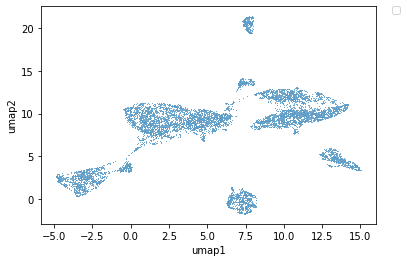

In [10]:
# convgnn

convgnn_after_pca = cnngnn_embed_sub
umap_fit = umap.UMAP(random_state=42)
umap_embed_convgnn = umap_fit.fit_transform(convgnn_after_pca)

# plot out
umap_embed_convgnn_df = pd.DataFrame(umap_embed_convgnn, columns = ['umap1', 'umap2'])
#umap_embed_convgnn_df['type'] = df['cluster.term'].values[indices]
#sns.scatterplot(data=umap_embed_convgnn_df, x='umap1', y='umap2', hue='type', s=1)
sns.scatterplot(data=umap_embed_convgnn_df, x='umap1', y='umap2', s=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [11]:
import sklearn.metrics

feature_ss_list = []
gnn_ss_list = []
covgnn_ss_list = []
k_clusters = [x for x in range(5,30,2)]

for k in k_clusters:
    
    ## feature only
    feature_edges = graph.get_feature_edges(
        arr=features_sub, pca_components=None,
        n_neighbors=15, metric='correlation', verbose=False
    )
    feature_labels = graph.graph_clustering(
        features_sub.shape[0], feature_edges, resolution=None, n_clusters=k, n_runs=1,
        resolution_tol=0.05, seed=None, verbose=False
    )
    
    ## gnn only
    feature_edges_gnn = graph.get_feature_edges(
        arr=gnn_embed_sub, pca_components=None,
        n_neighbors=15, metric='correlation', verbose=False
    )
    feature_labels_gnn = graph.graph_clustering(
        gnn_embed_sub.shape[0], feature_edges_gnn, resolution=None, n_clusters=k, n_runs=1,
        resolution_tol=0.05, seed=None, verbose=False
    )
    
    ## convGNN 
    feature_edges_conv = graph.get_feature_edges(
        arr=cnngnn_embed_sub, pca_components=None,
        n_neighbors=15, metric='correlation', verbose=False
    )
    feature_labels_conv = graph.graph_clustering(
        cnngnn_embed_sub.shape[0], feature_edges_conv, resolution=None, n_clusters=k, n_runs=1,
        resolution_tol=0.05, seed=None, verbose=False
    )
    
    feature_ss = sklearn.metrics.silhouette_score(umap_embed_feature, feature_labels)
    gnn_ss = sklearn.metrics.silhouette_score(umap_embed_gnn, feature_labels_gnn)
    covgnn_ss = sklearn.metrics.silhouette_score(umap_embed_convgnn, feature_labels_conv)
    
    feature_ss_list.append(feature_ss)
    gnn_ss_list.append(gnn_ss)
    covgnn_ss_list.append(covgnn_ss)
    

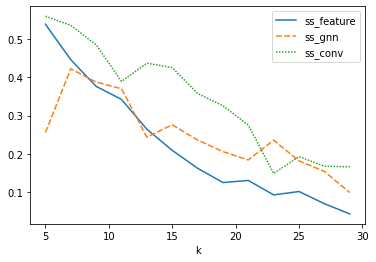

In [12]:
data = {'k':k_clusters, 'ss_feature':feature_ss_list, 'ss_gnn':gnn_ss_list,'ss_conv':covgnn_ss_list}
#data = {'k':k_clusters, 'ss_feature':feature_ss_list, 'ss_gnn':gnn_ss_list}

df = pd.DataFrame(data)
df = df.set_index('k')

sns.lineplot(data=df)

In [13]:
import leidenalg
import igraph as ig

def get_modularity(n,edges, seed = 42, resolution = 1):
    
    g = ig.Graph(directed=True)
    g.add_vertices(n)
    g.add_edges(list(zip(edges[0], edges[1])))
    g.es['weight'] = tuple(edges[2])
    partition_kwargs = {'n_iterations': -1, 'seed': seed,
                    'resolution_parameter': resolution}
    partition_kwargs['weights'] = np.array(g.es['weight']).astype(np.float64)
    partition_type = leidenalg.RBConfigurationVertexPartition
    curr_part = leidenalg.find_partition(
                graph=g, partition_type=partition_type,
                **partition_kwargs
            )
    curr_modularity = curr_part.modularity
    
    return curr_modularity

In [14]:
feature_md_list = []
gnn_md_list = []
covgnn_md_list = []
res_list = [round(x, 2) for x in np.arange (0.1, 2.5, 0.2)]

for res in res_list:
    
    feature_md = get_modularity(features_sub.shape[0], feature_edges, resolution = res)
    gnn_md = get_modularity(features_sub.shape[0], feature_edges_gnn, resolution = res)
    covgnn_md = get_modularity(features_sub.shape[0], feature_edges_conv, resolution = res)

    feature_md_list.append(feature_md)
    gnn_md_list.append(gnn_md)
    covgnn_md_list.append(covgnn_md)
    

In [15]:
data2 = {'res':res_list, 'md_feature':feature_md_list, 'md_gnn':gnn_md_list,'md_conv':covgnn_md_list}
#data2 = {'res':res_list, 'md_feature':feature_md_list, 'md_gnn':gnn_md_list}

df2 = pd.DataFrame(data2)
df2 = df2.set_index('res')
df2

,md_feature,md_gnn,md_conv
res,,,
0.1,0.665656,0.710931,0.713361
0.3,0.720888,0.765491,0.819451
0.5,0.727873,0.809642,0.819029
0.7,0.750534,0.815648,0.825428
0.9,0.753427,0.813773,0.830710
1.1,0.754204,0.806314,0.825615
1.3,0.749559,0.805173,0.819517
1.5,0.741003,0.801472,0.812331
1.7,0.731375,0.794397,0.812423


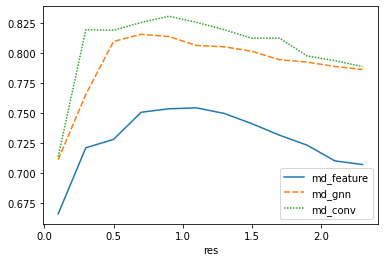

In [16]:
sns.lineplot(data=df2)